# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

In [1]:
#Imports

#Numpy: Used for getting random values for hyper-parameter tuning
import numpy as np

#Pandas: Used for loading the dataset
import pandas as pd

#Sklearn: Used for data preparation 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

#Pytorch: Used for ANN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim


In [2]:
#Get the dataset

df = pd.read_csv("Task 1.csv")
print(f'number of entries: {len(df)}')
print(f'columns: {[column for column in df.columns]}')
features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
targets = ['math score', 'reading score', 'writing score']
print(f"features: {features}")
print(f"targets: {targets}")
for feature in features:
  values = df[feature].unique()
  print(f'{feature}: {values}')

number of entries: 1000
columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']
features: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
targets: ['math score', 'reading score', 'writing score']
gender: ['male' 'female']
race/ethnicity: ['group A' 'group D' 'group E' 'group B' 'group C']
parental level of education: ['high school' 'some high school' 'some college' "associate's degree"
 "bachelor's degree" "master's degree"]
lunch: ['standard' 'free/reduced']
test preparation course: ['completed' 'none']


In [3]:
#Data preparation.
#References: Lab 2, 
#            Assignment 1 submission

#Features that have no natural ordered relationship
onehot_features = {
    'gender': ['male', 'female'],
    'race/ethnicity': ['group A', 'group B', 'group C', 'group D', 'group E'] 
}
#Features that have a natural ordered relationship
ordinal_features = {
    'parental level of education': ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"],
    'test preparation course': ['none', 'completed'],
    'lunch': ['standard', 'free/reduced']
}
#note that test preparation course and lunch features will be represented in the same way whether they get encoded ordinally or with one hot method

#Encoding categorical data
def ordinal_encoder(df, feature_name, categories):
  old_column = df[feature_name]
  old_column = np.array(old_column).reshape(-1,1)
  encoder = OrdinalEncoder(categories=[categories])
  new_column = encoder.fit_transform(old_column)
  new_column = pd.DataFrame(data=new_column, columns=[feature_name])
  new_df = df.drop(feature_name, axis=1)
  new_df = pd.concat([new_df, new_column], axis=1)
  return new_df

def onehot_encoder(df, features_names):
  encoder = OneHotEncoder(sparse=False, drop='first') #encoder model imported from sklearn
  new_columns = encoder.fit_transform(df[features_names])
  new_columns = pd.DataFrame(new_columns, dtype=int, columns=encoder.get_feature_names_out(features_names))
  new_df = df.drop(features_names, axis=1)
  new_df = pd.concat([new_df, new_columns], axis=1)   

  return new_df

def categorical_encoder(df, ordinal_features, onehot_features):
  new_df = df
  for key, val in ordinal_features.items():
    new_df = ordinal_encoder(new_df, key, val)
  onehot_features_names = []
  for key, val in onehot_features.items():
    onehot_features_names.append(key)
  new_df = onehot_encoder(new_df, onehot_features_names)
  return new_df

df = categorical_encoder(df=df, ordinal_features=ordinal_features, onehot_features=onehot_features)

print(f'columns: {[column for column in df.columns]}')

columns: ['math score', 'reading score', 'writing score', 'parental level of education', 'test preparation course', 'lunch', 'gender_male', 'race/ethnicity_group B', 'race/ethnicity_group C', 'race/ethnicity_group D', 'race/ethnicity_group E']


In [4]:
#Getting features and labels

X = df.iloc[:, 3:].values #Features
y = df.iloc[:, 0:3].values #Labels

In [5]:
#Scaling

def scaling(train, test, scaler=StandardScaler()):
  scaler.fit(train)
  train = scaler.transform(train)
  test = scaler.transform(test)
  return train, test

In [6]:
#Loading Custom Dataset in pytorch
#Reference: Self Practice 7

class CustumData(Dataset):
  def __init__(self, X, y):
    super().__init__()
    self.y = torch.tensor(y).float()
    self.X = torch.tensor(X).float()

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


In [7]:
#NN Model
#Reference: Lab 7 
#           Lab 9
#           https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
#           https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential

class Net(nn.Module):
  def __init__(self, units = 64, layers = 2, activation = nn.ReLU(), dropout = 0.25):
    super(Net, self).__init__()
    self.input = nn.Sequential(
      nn.Linear(8 ,units),
      activation
    )
    linear = nn.Sequential(
      nn.Linear(units, units),
      activation
    )
    self.linears = nn.ModuleList([linear for i in range(layers)])
    self.dropout = nn.Dropout(dropout)
    self.output = nn.Linear(units, 3)
    
  def forward(self, x):  
    x = self.input(x)
    for layer in self.linears:
      x = layer(x)
      x = self.dropout(x)
    x = self.output(x)
    return x


In [8]:
#Utility

def activation_function(name):
  activation_dict = {
    "relu": nn.ReLU(),
    "leaky": nn.LeakyReLU(),
    "elu": nn.ELU(),
    "hardswish": nn.Hardswish(),
    "selu": nn.SELU(),
    "silu": nn.SiLU()
  }
  return activation_dict[name]


In [9]:
#Training, Testing/Validation
#Reference: Lab7

def training(net, device, trainloader, criterion, optimizer):
  #Training
  net.train()
  train_loss = 0.0
  for data, targets in trainloader:
    data = data.to(device).float()
    targets = targets.to(device)

    optimizer.zero_grad()
  
    outputs = net(data)

    loss = criterion(outputs, targets)

    loss.backward()
    
    optimizer.step()
    
    train_loss += loss.item() * data.size(0)
    
  epoch_loss = train_loss / len(trainloader.dataset)
  return epoch_loss

def testing(net, device, testloader, criterion):
  #Validation/Testing
  net.eval()
  test_loss = 0.0
  for data, targets in testloader:
    with torch.no_grad():
      data = data.to(device).float()
      targets = targets.to(device)

      outputs = net(data)

      loss = criterion(outputs, targets)
                
      test_loss += loss.item() * data.size(0)
      
  epoch_loss = test_loss / len(testloader.dataset)
  return epoch_loss

def process(units, layers, active, lr, momentum, batch_size, dropout, epochs):
  activation = activation_function(active)

  net = Net(units, layers, activation, dropout)

  optimizer = optim.SGD(net.parameters(), lr, momentum)

  criterion = nn.L1Loss()  

  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda"
  
  net.to(device)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2) #split 80/20

  X_train, X_test = scaling(X_train, X_test, StandardScaler())

  trainset = CustumData(X_train, y_train)
  testset = CustumData(X_test, y_test) 

  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

  min_loss = 4*11*1001
  log_interval = 50
  for epoch in range(epochs):
    train_loss= training(net, device, trainloader, criterion, optimizer)
    val_loss = testing(net, device, testloader, criterion)
    if epoch%log_interval == 0 or epoch == epochs-1:
      print('---------------------------------------------------\n')
      print(f'Epoch {epoch+1}/{epochs}:')
      print(f'Train:')
      print(f'\tLoss: {train_loss}')  
      print(f'Validation:')
      print(f'\tLoss: {val_loss}\n')
      print('---------------------------------------------------')
    if val_loss <= min_loss:
      min_loss = val_loss

  return min_loss

In [ ]:
#Hyperparameter Tuning

def main_task1(num_samples=20, num_epochs=100):
  best_epoch_loss = 1e9
  best_units, best_layers, best_active, best_lr, best_momentum, best_batch_size, best_dropout = None, None, None, None, None, None, None
  for i in range(num_samples):
    print('____________________________________________________________________\n')
    print(f'Sample {i+1}/{num_samples}')
    print('____________________________________________________________________\n')
      
    units = 2 ** np.random.randint(3, 7)
    layers = np.random.randint(1, 5)
    active = np.random.choice(["relu", "leaky", "elu", "hardswish", "selu", "silu"])
    lr = np.random.uniform(0.1, 0.00001)
    momentum = np.random.uniform(0.0, 1.0)
    batch_size = 2 ** np.random.randint(5, 10)
    dropout = np.random.uniform(0.0, 0.5)
    
    epoch_loss = process(units, layers, active, lr, momentum, batch_size, dropout, num_epochs)

    if epoch_loss < best_epoch_loss:
      best_epoch_loss = epoch_loss
      best_units, best_layers, best_active, best_lr, best_momentum, best_batch_size, best_dropout = units, layers, active, lr, momentum, batch_size, dropout

  print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n')
  print("Best Sample:")
  print(f'\tLoss: {best_epoch_loss}')
  print(f'\t\tUnits: {best_units}')
  print(f'\t\tHidden Layers: {best_layers}')
  print(f'\t\tActivation Function: {best_active}')
  print(f'\t\tLearning Rate: {best_lr}')
  print(f'\t\tMomentum: {best_momentum}')
  print(f'\t\tBatch Size: {best_batch_size}')
  print(f'\t\tDropout Probability: {best_dropout}')
  print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n')
  
    
main_task1(200, 100)

Streaming output truncated to the last 5000 lines.
---------------------------------------------------

Epoch 1/100:
Train:
	Loss: 67.39689788818359
Validation:
	Loss: 68.61956024169922

---------------------------------------------------
---------------------------------------------------

Epoch 51/100:
Train:
	Loss: 13.164575805664063
Validation:
	Loss: 11.944896697998047

---------------------------------------------------
---------------------------------------------------

Epoch 100/100:
Train:
	Loss: 12.397598876953126
Validation:
	Loss: 11.017986297607422

---------------------------------------------------
____________________________________________________________________

Sample 46/200
____________________________________________________________________

---------------------------------------------------

Epoch 1/100:
Train:
	Loss: 67.33331939697266
Validation:
	Loss: 66.14340072631836

---------------------------------------------------
------------------------------------

Note: Some samples produce L1Loss equal to NaN.
- After investigating the issue for a long time I came to the conclusion that some samples extremly diverge and python just can't keep up.
- Since we're only looking for the best model and the majority of the samples run fine, I decided to not focus on this issue because it doesn't really affect our end goal.


### Questions
1. What preprocessing techniques did you use? Why?
    - Encoding:
      - OneHotEncoding
        - Features: 
          - gender 
          - race/ethnicity 
        - Reasoning: 
          - Because gender and race do not have a natural ordered relationship in themselves. So, one hot encoding is the appropriate here.
      - OrdinalEncoding:
        - Features: 
          - parental level of education  
          - test preparation course 
          - lunch 
        - Reasoning: 
          - parental level of education: there's a natural order from uneducated to educated.
          - Order:
            - some high school -> 0  
            - high school -> 1 
            - some college -> 2 
            - associate's degree -> 3 
            - bachelor's degree -> 4 
            - master's degree -> 5 
          - lunch: there's a natural order in terms of what is better, free/reduced or full priced. 
          - Order:
            - standard -> 0 
            - free/reduced -> 1 
          - test preparation course: there's a natural order in terms of who is prepared and not.
          - Order:
            - none -> 0 
            - completed -> 1 
      - Note: For the lunch and test preparation course features, both OneHotEncoding and OrdinalEncoding are valid due to the fact that there's only 2 possible values for each feature.
    - Scaling
      - Used standard scaler to scale the dataset
      - Reasoning: to make all features contribute equally instead of having ordinally encoded features(parental level of education) have more weight than other features.
2. Describe the fine-tuning process and how you reached your model architecture.
   
    - Fine-tuning: 
      - Number of Layers:
        - Possible values: \[1, 2, 3, 4, 5]
        - Reason: in most of my test runs the best model had 1 or 2 layers, and having more than 5 will make the code slower
      - Number of Neurons: 
        - Possible values: \[8, 16, 32, 64, 128]  
        - Reason: in most of my test runs the best model had 32 or 64 Neurons, and having more than 128 will make the code slower 
      - Activation Functions:
        - Possible functions: 
            - ReLU
            - LeakyReLU
            - Hardswish
            - ELU
            - SELU
            - SiLU
        - Reason: We were told in labs that ReLU is the most common one and we should use it in most cases. And, I did not want to include all available functions, because it will need me to run the code for a much larger number of samples to have a good variaty of tests. 
      - Learning Rate:
        - Possible values: a random float between 10^-1 and 10^-5
        - Reason: A good margin and it will give various results
      - Momentum: 
        - Possible values: a random float between 0.0 and 1.0
      - Regularization: 
        - Dropout Probability: 
          - Possible values: a random float between 0.0 and 0.5
          - Reason: based on lecture 10 best dropout probability is between 0.2 and 0.5 but it was mentioned that sometimes lower than that might be better. So, I decided to give it from 0.0 to 0.5 with the trade off that I will run the code for a larger number of samples.
      - Note: I went with the assumption that you wanted us to use SGD as an optimizer based on the following facts:
        - You asked us to tune Momentum
        - We only used Adam and SGD optimizers in the course
      - Batch Size: 
        - Possible values: \[32, 64, 128, 256, 512]
        - Reason: Although it wasn't mentioned in the problem statement, I wanted to test it out since the most harm it could do is make the code a little slower. 
    - After running for 200 samples where each sample ran for 100 epochs, the best samples was the following:
      - L1Loss: 9.213712348937989
      - Number of Layers: 1 
      - Number of Neurons: 32
      - Learning Rate: 0.043822707037253474
      - Momuntem: 0.40165118469844885
      - Activiation Function: LeakyReLU
      - Batch Size: 32
      - Dropout Probability: 0.06738041099465714

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

In [10]:
#Imports


#Pytorch: Used for CNN
import torchvision
import torchvision.transforms as transforms


import zipfile
import cv2
import os
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

In [13]:
#Unzip the data file and extracting to task2 directory
#Reference: https://stackoverflow.com/questions/3451111/unzipping-files-in-python

with zipfile.ZipFile('triple_mnist.zip', 'r') as zip_ref:
    zip_ref.extractall('/task2/')

In [14]:
#Parsing a directory of images into greyscale and transforming it to a tensor 
#Reference: Lab 9 
#           https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
#           https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor

def parse_data(dir):
  X = []
  y = []
  tr = transforms.ToTensor()
  for d in os.listdir(dir):
    for img in os.listdir(f'{dir}/{d}'):
      datum = plt.imread(f'{dir}/{d}/{img}')
      datum = rgb2gray(datum)
      datum = tr(datum)  
      X.append(datum)
      y.append(d)
  return X, y

In [15]:
#Loading Custom Dataset in pytorch
#Reference: Self Practice 7
#           Lab 10

class CustumData(Dataset):
  def __init__(self, X, y, augmentation = None):
    super().__init__()
    self.X = X
    self.y = y
    self.augmentation = augmentation

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    img = self.X[idx]
    if self.augmentation:
      img = self.augmentation(self.X[idx])
    return img, self.y[idx]

In [16]:
#Getting the split data from the unzipped directories
#Reference: Lab 10
#           https://pytorch.org/vision/stable/transforms.html
#           https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose

X_train, y_train = parse_data('/task2/triple_mnist/train')
X_val, y_val = parse_data('/task2/triple_mnist/val')
X_test, y_test = parse_data('/task2/triple_mnist/test')

train_transforms = transforms.Compose([
    transforms.RandomRotation(15), # Only logical thing since other types of transformations will either not be useful or will change the numbers
    transforms.Normalize((0.5), (0.5))
])

test_transforms = transforms.Compose([
    transforms.Normalize((0.5), (0.5))
])

train_data = CustumData(X_train, y_train, train_transforms)
val_data = CustumData(X_val, y_val, test_transforms)
test_data = CustumData(X_test, y_test, test_transforms)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  del sys.path[0]


In [17]:
#NN Model
#Reference: Lab 7, 
#           https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html, 
#           https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential
#           Lab 9, 

#Same as before just change input and output and return a list of 3 values in forward
class Net(nn.Module):
  def __init__(self, units = 64, layers = 2, activation = nn.ReLU(), dropout = 0.25):
    super(Net, self).__init__()
    self.input = nn.Sequential(
      nn.Linear(84*84 ,units),
      activation
    )
    linear = nn.Sequential(
      nn.Linear(units, units),
      activation
    )
    self.linears = nn.ModuleList([linear for i in range(layers)])
    self.dropout = nn.Dropout(dropout)
    self.output = nn.Linear(units, 30)

  def forward(self, x):  
    x = x.view(-1, 84*84)
    x = self.input(x)
    for layer in self.linears:
      x = layer(x)
      x = self.dropout(x)
    x = self.output(x)
    n1 = x[:, :10]
    n2 = x[:, 10:20]
    n3 = x[:, 20:30]
    return [n1,n2,n3]


In [31]:
#Training, Testing/Validation
#Reference: Lab 9 


def training(net, device, trainloader, criterion, optimizer):
  #Training
  net.train()
  train_loss = 0.0
  train_corrects = 0
  for data, targets in trainloader:
    data = data.to(device).float()
    targets = torch.tensor([[int(target[0]), int(target[1]), int(target[2])] for target in targets])
    targets = targets.to(device)
    
    optimizer.zero_grad()
  
    outputs = net(data)

    loss = 0
    for i in range(3):
      loss += criterion(outputs[i], targets[:, i])
      preds = torch.max(outputs[i], 1)[1]
      train_corrects += torch.sum(preds == targets[:, i])
    loss /= 10
    loss.backward()
    
    optimizer.step()
    
    train_loss += loss.item() * data.size(0)

  epoch_loss = train_loss / len(trainloader.dataset)
  epoch_acc = train_corrects.double() / (len(train_data)*3)
  return epoch_loss, epoch_acc
  

def testing(net, device, testloader, criterion):
  #Validation/Testing
  net.eval()
  test_loss = 0.0
  test_corrects = 0
  for data, targets in testloader:
    with torch.no_grad():
      data = data.to(device).float()
      targets = torch.tensor([[int(target[0]), int(target[1]), int(target[2])] for target in targets])
      targets = targets.to(device)
      
      outputs = net(data)
      
      loss = 0
      for i in range(3):
        loss = criterion(outputs[i], targets[:, i])
        preds = torch.max(outputs[i], 1)[1]
        test_corrects += torch.sum(preds == targets[:, i])
      loss /= 10
      test_loss += loss.item() * data.size(0)
      
  epoch_loss = test_loss / len(testloader.dataset)
  epoch_acc = test_corrects.double() / (len(test_data)*3)
  return epoch_loss, epoch_acc

def process(units, layers, activation, momentum, lr, batch_size, dropout):
  net = Net(units, layers, activation, dropout)
  
  optimizer = optim.SGD(net.parameters(), momentum=momentum,lr=lr) 
  
  criterion = nn.CrossEntropyLoss() #Change the loss to adapt for the classification problem
  
  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda"
  
  net.to(device)


  trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  validloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  
  for epoch in range(100):
    train_loss, train_acc = training(net, device, trainloader, criterion, optimizer)
    val_loss, val_acc = testing(net, device, validloader, criterion)
    print('---------------------------------------------------\n')
    print(f'Epoch: {epoch+1}')
    print(f'Train:')
    print(f'\tLoss: {train_loss}')
    print(f'\tAccuracy: {train_acc}')
    print(f'Validation:')
    print(f'\tLoss: {val_loss}')
    print(f'\tAccuracy: {val_acc}')
    print('---------------------------------------------------')
  test_loss, test_acc = testing(net, device, testloader, criterion)
  print(f'Test:')
  print(f'\tLoss: {test_loss}')
  print(f'\tAccuracy: {test_acc}')
  return net
  
  

In [32]:
#Main
def main_task2_1():
# L1Loss: 9.213712348937989
#       - Number of Layers: 1 
#       - Number of Neurons: 32
#       - Learning Rate: 0.043822707037253474
#       - Momuntem: 0.40165118469844885
#       - Activiation Function: LeakyReLU
#       - Batch Size: 32
#       - Dropout Probability: 0.06738041099465714
  units = 32
  layers = 1
  activation = nn.LeakyReLU()
  lr = 0.043822707037253474
  momentum = 0.40165118469844885
  batch_size = 32
  dropout = 0.06738041099465714
  model = process(units, layers, activation, momentum, lr, batch_size, dropout)
  return model

best_task2_1 = main_task2_1()

---------------------------------------------------

Epoch: 1
Train:
	Loss: 0.6906634705364704
	Accuracy: 0.10835416666666667
Validation:
	Loss: 0.2314030497968197
	Accuracy: 0.05666666666666667
---------------------------------------------------
---------------------------------------------------

Epoch: 2
Train:
	Loss: 0.6891287945508957
	Accuracy: 0.11859895833333332
Validation:
	Loss: 0.2307731391489506
	Accuracy: 0.08466666666666667
---------------------------------------------------
---------------------------------------------------

Epoch: 3
Train:
	Loss: 0.6827908050119876
	Accuracy: 0.14086458333333332
Validation:
	Loss: 0.22751371133327483
	Accuracy: 0.1101
---------------------------------------------------
---------------------------------------------------

Epoch: 4
Train:
	Loss: 0.6758543344140053
	Accuracy: 0.15140104166666665
Validation:
	Loss: 0.22602736920118333
	Accuracy: 0.12983333333333333
---------------------------------------------------
-----------------------

In [22]:
#CNN 
#Reference: Lab 9
#           Lab 10 


class CNN(nn.Module):
    def __init__(self, first_out_channel, hidden_out_channel, first_filter, hidden_filter, layers, activation, dropout):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, first_out_channel, first_filter), 
            activation,
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(first_out_channel),
        )
        self.first_layer = nn.Sequential(
            nn.Conv2d(first_out_channel, hidden_out_channel, hidden_filter),
            activation,
            nn.BatchNorm2d(hidden_out_channel),
        )
        conv_layer = nn.Sequential(
            nn.Conv2d(hidden_out_channel, hidden_out_channel, hidden_filter),
            activation,
            nn.BatchNorm2d(hidden_out_channel),
        )
        self.conv_layers = nn.ModuleList([conv_layer for i in range(layers)])

        self.fully_connected1 = nn.Sequential(
            nn.LazyLinear(128),
            activation,
        )
        self.fully_connected2 = nn.Sequential(
            nn.Linear(128, 64),
            activation,
        )
        self.out = nn.Linear(64, 30)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv(x)
        x = self.first_layer(x)
        for conv_layer in self.conv_layers:
          x = conv_layer(x)
          x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fully_connected1(x)
        x = self.dropout(x)
        x = self.fully_connected2(x)
        x = self.dropout(x)
        x = self.out(x)
        n1 = x[:, :10]
        n2 = x[:, 10:20]
        n3 = x[:, 20:30]
        return [n1, n2, n3]



In [23]:

def process(input_units, output_units, input_filter, hidden_filter, layers, active, momentum, lr, batch_size, dropout, epochs, final=False):
  activation = activation_function(active)
  
  net = CNN(input_units, output_units, input_filter, hidden_filter, layers, activation, dropout)
  
  optimizer = optim.SGD(net.parameters(), lr, momentum)
  
  criterion = nn.CrossEntropyLoss() 
  
  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda"
  
  net.to(device)

  trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  validloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

  best_acc = 0

  for epoch in range(epochs):
    print('---------------------------------------------------')
    print(f'Epoch: {epoch+1}/{epochs}')
    train_loss, train_acc = training(net, device, trainloader, criterion, optimizer)
    print(f'Train:')
    print(f'\tLoss: {train_loss}')
    print(f'\tAccuracy: {train_acc}')
    val_loss, val_acc = testing(net, device, validloader, criterion)
    print(f'Validation:')
    print(f'\tLoss: {val_loss}')
    print(f'\tAccuracy: {val_acc}')
    print('---------------------------------------------------')
    if val_acc >= best_acc:
      best_acc = val_acc
  if final:
    test_loss, test_acc = testing(net, device, testloader, criterion)
    print('===================================================')
    print('Test:')
    print(f'\tLoss: {test_loss}')
    print(f'\tAccuracy: {test_acc}')
    print('===================================================')
    best_acc = test_acc
  return best_acc, net
  

In [ ]:
#Main

def main_task2_2(num_samples=20, num_epochs=10):
  best_acc = 0
  best_net = None
  best_input_units, best_output_units, best_input_filter, best_hidden_filter, best_layers, best_active, best_lr, best_momentum, best_batch_size, best_dropout = None, None, None, None, None, None, None, None, None, None
  for i in range(num_samples):
    print('____________________________________________________________________\n')
    print(f'Sample {i+1}/{num_samples}')
    print('____________________________________________________________________\n')
      
    input_units = 2 ** np.random.randint(1, 6)
    output_units = 2 ** np.random.randint(1, 6)
    input_filter = np.random.choice([3,5])
    hidden_filter = np.random.choice([3,5])
    layers = np.random.randint(1, 5)
    active = np.random.choice(["relu", "leaky", "elu", "hardswish", "selu", "silu"])
    lr = np.random.uniform(0.1, 0.00001)
    momentum = np.random.uniform(0, 1.0)
    batch_size = 4 ** np.random.randint(3, 6)
    dropout = np.random.uniform(0, 0.5)
    
    sample_acc, sample_net = process(input_units, output_units, input_filter, hidden_filter, layers, active, momentum, lr, batch_size, dropout, num_epochs)

    if sample_acc > best_acc:
      best_acc = sample_acc
      best_net = sample_net
      best_input_units, best_output_units, best_input_filter, best_hidden_filter, best_layers, best_active, best_lr, best_momentum, best_batch_size, best_dropout = input_units, output_units, input_filter, hidden_filter, layers, active, lr, momentum, batch_size, dropout

  print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n')
  print("Best Sample:")
  print(f'\tAccuracy: {best_acc}')
  print(f'\tInput Output Channels: {best_input_units}')
  print(f'\tHidden Output Channels: {best_output_units}')
  print(f'\tInput Kernel: {best_input_filter}')
  print(f'\tHidden Kernel: {best_hidden_filter}')
  print(f'\t\tHidden Layers: {best_layers}')
  print(f'\t\tLearning Rate: {best_lr}')
  print(f'\t\tMomentum: {best_momentum}')
  print(f'\t\tBatch Size: {best_batch_size}')
  print(f'\t\tDropout Probability: {best_dropout}')
  print(f'\t\tActivation Function: {best_active}')
  print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n')
  
  return best_net

best_hypertune_cnn = main_task2_2(5, 25)

____________________________________________________________________

Sample 1/5
____________________________________________________________________



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


---------------------------------------------------
Epoch: 1/25
Train:
	Loss: 0.7007718977928161
	Accuracy: 0.12698437499999998
Validation:
	Loss: 0.21745612728595734
	Accuracy: 0.20563333333333333
---------------------------------------------------
---------------------------------------------------
Epoch: 2/25
Train:
	Loss: 0.6479294838905334
	Accuracy: 0.20060416666666667
Validation:
	Loss: 0.19720813894271852
	Accuracy: 0.2813833333333334
---------------------------------------------------
---------------------------------------------------
Epoch: 3/25
Train:
	Loss: 0.6053323397636413
	Accuracy: 0.25271354166666665
Validation:
	Loss: 0.19856909573078155
	Accuracy: 0.27575
---------------------------------------------------
---------------------------------------------------
Epoch: 4/25
Train:
	Loss: 0.5683043313026428
	Accuracy: 0.296703125
Validation:
	Loss: 0.20344017302989958
	Accuracy: 0.305
---------------------------------------------------
-----------------------------------

In [24]:
def main_task2_2_best(num_epochs):
  input_units = 4
  output_units = 8
  input_filter = 3
  hidden_filter = 5
  layers = 1
  active = "leaky"
  lr = 0.062128695444829546
  momentum = 0.33922085849116246
  batch_size = 256
  dropout = 0.005428947811590701
  
  sample_acc, sample_net = process(input_units, output_units, input_filter, hidden_filter, layers, active, momentum, lr, batch_size, dropout, num_epochs, final=True)
  
  return sample_net
best_cnn = main_task2_2_best(50)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


---------------------------------------------------
Epoch: 1/50
Train:
	Loss: 0.6709928939342499
	Accuracy: 0.18438541666666666
Validation:
	Loss: 0.20429083228111267
	Accuracy: 0.26021666666666665
---------------------------------------------------
---------------------------------------------------
Epoch: 2/50
Train:
	Loss: 0.42453560316562655
	Accuracy: 0.5168177083333333
Validation:
	Loss: 0.2046163569688797
	Accuracy: 0.22353333333333333
---------------------------------------------------
---------------------------------------------------
Epoch: 3/50
Train:
	Loss: 0.21105537366867066
	Accuracy: 0.7760833333333333
Validation:
	Loss: 0.29511822485923767
	Accuracy: 0.3415
---------------------------------------------------
---------------------------------------------------
Epoch: 4/50
Train:
	Loss: 0.1273428860604763
	Accuracy: 0.8733385416666667
Validation:
	Loss: 0.47874233865737914
	Accuracy: 0.12190000000000001
---------------------------------------------------
---------------

In [53]:
#Measuring speed for a model
import time

def testing_speed(net, device, testloader, criterion):
  #Validation/Testing
  net.eval()
  test_loss = 0.0
  test_corrects = 0
  all_time = 0
  for data, targets in testloader:
    ann_time = time.monotonic()
    with torch.no_grad():
      data = data.to(device).float()
      targets = torch.tensor([[int(target[0]), int(target[1]), int(target[2])] for target in targets])
      targets = targets.to(device)
      
      outputs = net(data)
      
      loss = 0
      for i in range(3):
        loss = criterion(outputs[i], targets[:, i])
        preds = torch.max(outputs[i], 1)[1]
        test_corrects += torch.sum(preds == targets[:, i])
      loss /= 10
      test_loss += loss.item() * data.size(0)
    all_time += (time.monotonic() - ann_time)
    #print(all_time)
  epoch_loss = test_loss / len(testloader.dataset)
  epoch_acc = test_corrects.double() / (len(test_data)*3)
  all_time = all_time/(len(testloader.dataset)/50)
  return epoch_loss, epoch_acc, all_time

def get_speed(net):
  criterion = nn.CrossEntropyLoss() 
  
  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda"
  
  net.to(device)

  testloader = DataLoader(test_data, batch_size=50, shuffle=True)

  test_loss, test_acc, test_time = testing_speed(net, device, testloader, criterion)
  print(f'\tLoss: {test_loss}')
  print(f'\tAccuracy: {test_acc}')
  return test_acc, test_time
  

In [54]:
#Count parameters
#Reference: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325

def count_parameters(model): 
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [55]:
#Measuring speed for ANN model
ANN_parameters = count_parameters(best_task2_1)
ANN_acc, ANN_speed = get_speed(best_task2_1)

	Loss: 0.19420661445707083
	Accuracy: 0.35486666666666666


In [56]:
#Measuring speed for CNN model

CNN_parameters = count_parameters(best_cnn)
CNN_acc, CNN_speed = get_speed(best_cnn)

	Loss: 0.017753391618898603
	Accuracy: 0.9516666666666667


In [57]:
#Printing speeds and parameters 

print(f'ANN Accuracy {ANN_acc}')
print(f'ANN Speed: {ANN_speed}')
print(f'ANN Number of Parameters: {ANN_parameters}\n')
print(f'CNN Accuracy {CNN_acc}')
print(f'CNN Speed: {CNN_speed}')
print(f'CNN Number of Parameters: {CNN_parameters}\n')

ANN Accuracy 0.35486666666666666
ANN Speed: 0.0014094984275516253
ANN Number of Parameters: 227870

CNN Accuracy 0.9516666666666667
CNN Speed: 0.0021250320449826177
CNN Number of Parameters: 1127966



### Comparison

- ANN: 
  - Accuracy: 35.48666%
  - Number of Parameters: 227870
  - Speed of inference: 0.0014094984275516253 seconds
- CNN: 
  - Accuracy: 95.16666%
  - Parameters: 1127966
  - Speed of inference: 0.0021250320449826177 seconds

  

- Other remarks:
  - Please keep in mind that I trained the ANN model for 100 epochs and the CNN model for 50 epochs
  - The ANN model showes a small improvement the more epochs it trains in
  - the CNN model showed significant improvement for the first 10 to 15 epochs then the improvment  stagnated.

-------------------------------------------------------------------

### Questions
1. What preprocessing techniques did you use? Why?
    - First: I unzipped the data and put it in a specific folder called "task2", where it will have a folder called "triple_mnist" consisting of 3 folders for train, validation and test.
    - Second: I iterate through the files and retrieve the images and labels(from the folder name)

    - Preporcessing: 
      - Read the image using imread
      - gray scale the image using rgbtogray
        - Reason: to easily make a model that works with one channel instead of 3
      - turn it to a tensor using transforms.ToTensor
        - Reason: to be able to process it in my model with pytorch
2. What data augmentation techniques did you use?
    - In training I used a random rotation of 15 degrees 
    - Reason: To get a model that is robust and can predict the answers from a adjusted data
3. Describe the fine-tuning process and how you reached your final CNN model.
    - Fine-tuning: 
      - Number of Layers:
        - Possible values: \[1, 2, 3, 4, 5]
        - Reason: in most of my test runs the best model had 1 or 2 layers, and having more than 5 will make the code slower
      - Number of Input Layer Out Channels: 
        - Possible values: \[2, 4, 8, 16, 32, 64]
        - Reason: It will give a good variaty, without slowing the code.
      - Number of Hidden Layers In and Out Channels:
        - Possible values: \[2, 4, 8, 16, 32, 64]
        - Reason: It will give a good variaty, without slowing the code.
      - Size of Input Layer Kernel
        - Possible values: \[3, 5]
        - Reason Because it is best practice to have an odd valued kernel so we would have a point of focus.
      - Size of Hidden Layer Kernels
        - Possible values: \[3, 5]
        - Reason: Because it is best practice to have an odd valued kernel so we would have a point of focus.
      - Activation Functions:
        - Possible functions: 
            - ReLU
            - LeakyReLU
            - Hardswish
            - ELU
            - SELU
            - SiLU
        - Reason: We were told in labs that ReLU is the most common one and we should use it in most cases. And, I did not want to include all available functions, because it will need me to run the code for a much larger number of samples to have a good variaty of tests. 
      - Learning Rate:
        - Possible values: a random float between 10^-1 and 10^-5
        - Reason: A good margin and it will give various results
      - Momentum: 
        - Possible values: a random float between 0.0 and 1.0
      - Regularization: 
        - Dropout Probability: 
          - Possible values: a random float between 0.0 and 0.5
          - Reason: based on lecture 10 best dropout probability is between 0.2 and 0.5 but it was mentioned that sometimes lower than that might be better. So, I decided to give it from 0.0 to 0.5 with the trade off that I will run the code for a larger number of samples.
      - Note: I went with the assumption that you wanted us to use SGD as an optimizer based on the following facts:
        - You asked us to tune Momentum
        - We only used Adam and SGD optimizers in the course
      - Batch Size: 
        - Possible values: \[64, 256, 1024, 4096]
        - Reason: Although it wasn't mentioned in the problem statement, I wanted to test it out since the most harm it could do is make the code a little slower. 
    - After running for 5 samples where each sample ran for 25 epochs, the best samples was the following:
      - Accuracy on validation: 0.7689
      - Number of Layers: 1 
      - Number of Input Layer Out Channels: 4
      - Number of Hidden Layers In and Out Channels: 8
      - Size of Input Layer Kernel: 3
      - Size of Hidden Layer Kernels: 5
      - Learning Rate: 0.062128695444829546
      - Momuntem: 0.33922085849116246
      - Activiation Function: LeakyReLU
      - Batch Size: 256
      - Dropout Probability: 0.005428947811590701
    - After running the best model on its own for 50 epochs:
      - Accuracy on Test: 0.9516666666666667

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [65]:
#Imports

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import graphviz


In [66]:
#Get the dataset

df = pd.read_csv("loan_data.csv")
print(df['purpose'].unique())
print(f'number of entries: {len(df)}')
print(f'columns: {[column for column in df.columns]}')

['debt_consolidation' 'credit_card' 'all_other' 'home_improvement'
 'small_business' 'major_purchase' 'educational']
number of entries: 9578
columns: ['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid']


In [67]:
#Data preparation

onehot_features = {
    'purpose': ['debt_consolidation', 'credit_card', 'all_other', 'home_improvement', 'small_business', 'major_purchase', 'educational']
}
ordinal_features = {}

df = categorical_encoder(df=df, ordinal_features=ordinal_features, onehot_features=onehot_features)

print(f'columns: {[column for column in df.columns]}')


columns: ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business']


In [68]:
#Getting features and target

X = df.iloc[:, 1:]
y = df['credit.policy']

In [80]:
#Splitting and scaling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_train, X_test = scaling(X_train, X_test, StandardScaler())

In [70]:
#Training
#Reference: Lab 4

def train(model, param_grid, scoring='accuracy', cv=5):
  clf = GridSearchCV(
    estimator=model,
    cv=cv,
    scoring=scoring,
    param_grid=param_grid
  )
  clf.fit(X_train, y_train)
  best_params = clf.best_params_
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  return acc, best_params


In [71]:
#Decision Tree
#Reference: https://www.projectpro.io/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python

DT_param_grid = {
  "criterion": ["gini", "entropy"],
  "splitter": ["best", "random"],
  "max_depth": [2*i for i in range(1, 10)],
  "min_samples_leaf": [4**i for i in range(4)],
  "max_features": ["sqrt", "log2", None]
}

DT_acc, DT_params = train(DecisionTreeClassifier(), DT_param_grid)

In [73]:
#Random Forest
#Reference: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

RF_param_grid = {
  "criterion": ["gini", "entropy"],
  "max_depth": [2*i for i in range(1, 10)],
  "max_features": ["sqrt", "log2", None],
  'n_estimators': [50*i for i in range(1,4)]
}

RF_acc, RF_params = train(RandomForestClassifier(), RF_param_grid)

In [74]:
#Compare

print(f'Best:')
print(f'\tDecision Tree:')
print(f'\t\taccuracy: {DT_acc}\n\t\tParameters: {DT_params}')
print(f'\tRandom Forest:')
print(f'\t\tRF accuracy: {RF_acc}\n\t\tParameters: {RF_params}')

Best:
	Decision Tree:
		accuracy: 0.9890396659707724
		Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'splitter': 'best'}
	Random Forest:
		RF accuracy: 0.9895615866388309
		Parameters: {'criterion': 'entropy', 'max_depth': 16, 'max_features': None, 'n_estimators': 100}


In [75]:
#Visualization
#Reference: Lab 11

task4_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business']
task4_classes = ['0', '1'] 

def plot_tree(clf, features=task4_features, classes=task4_classes):
    dot_data = tree.export_graphviz(clf, out_file=None,
                       feature_names=features,
                       class_names=classes,
                       filled=True, rounded=True,
                       special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph


In [81]:
#Retraining models with best params

def train(model):
  clf = model
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_pred, y_test)
  return clf, acc

DT = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=None, min_samples_leaf=1, splitter='best')
RF = RandomForestClassifier(criterion='entropy', max_depth=16, max_features=None, n_estimators=100)

DT_clf, DT_acc = train(DT)
RF_clf, RF_acc = train(RF)

print(f'Decision Tree Accuracy: {DT_acc}')
print(f'Random Forest Accuracy: {RF_acc}')


Decision Tree Accuracy: 0.9921711899791231
Random Forest Accuracy: 0.9947807933194155


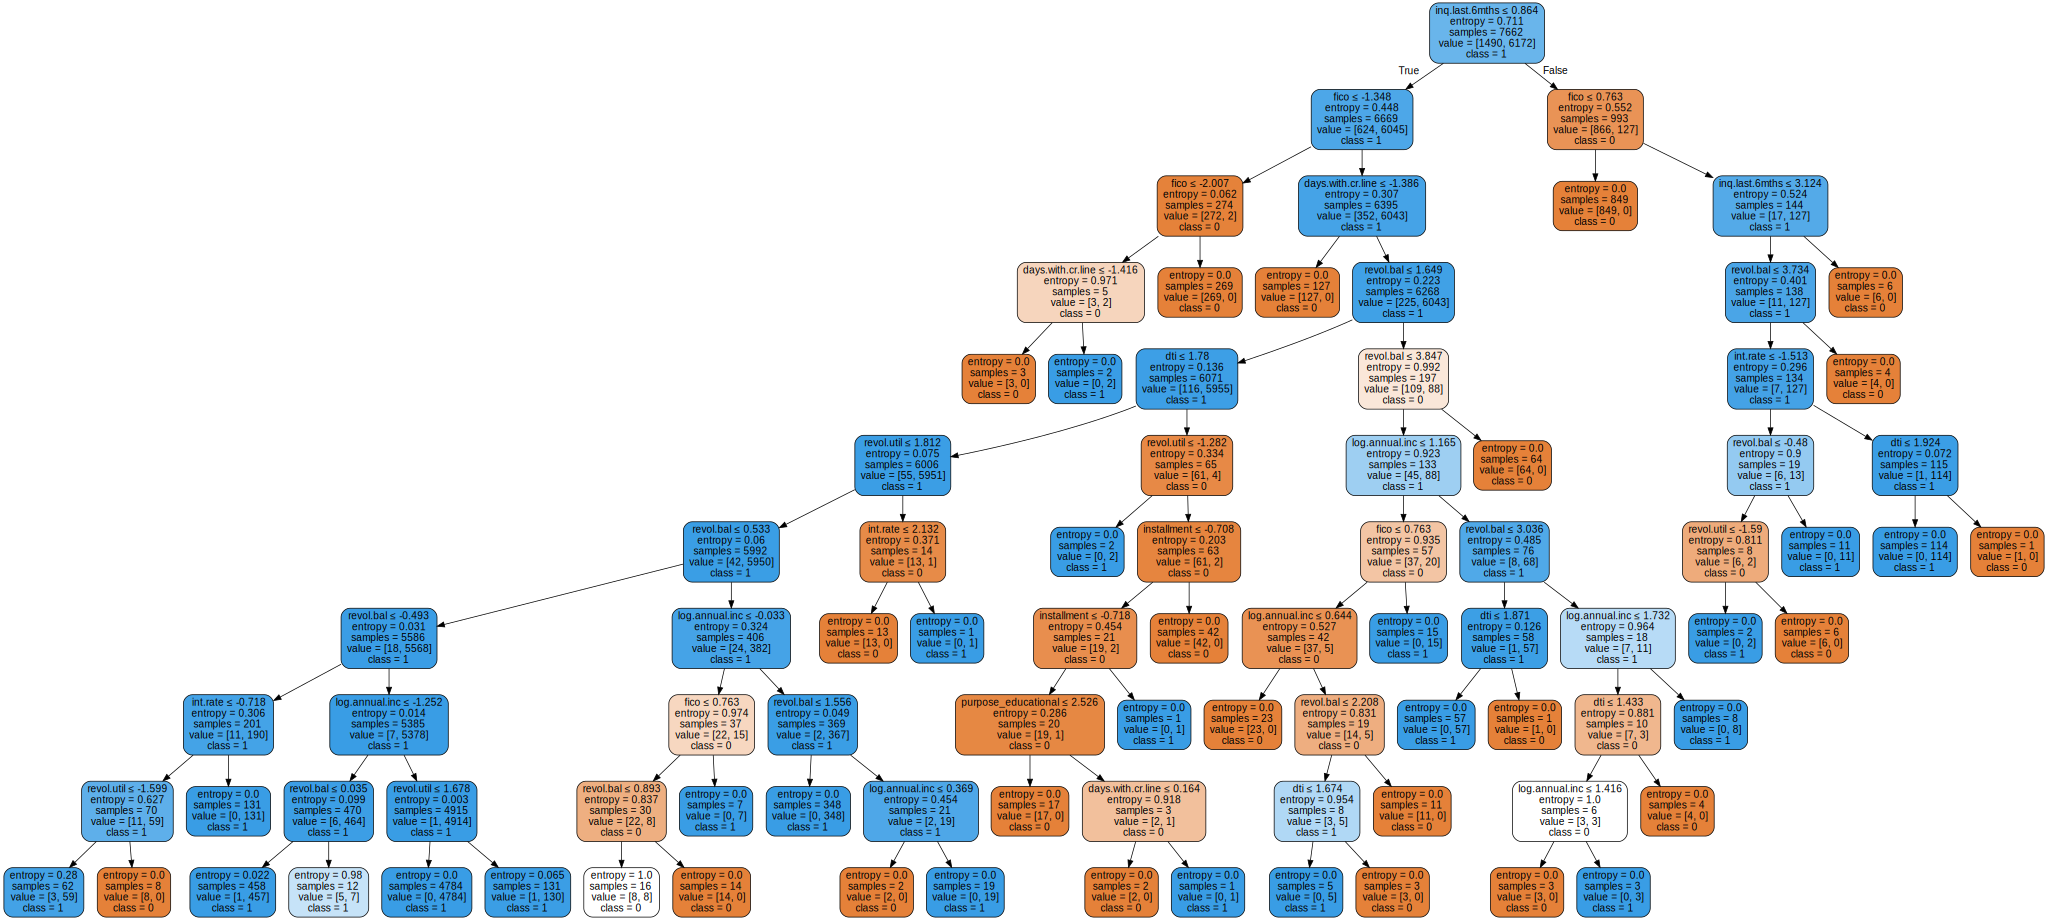

In [82]:
#Decision Tree Visualization

graph = plot_tree(DT_clf)
graph

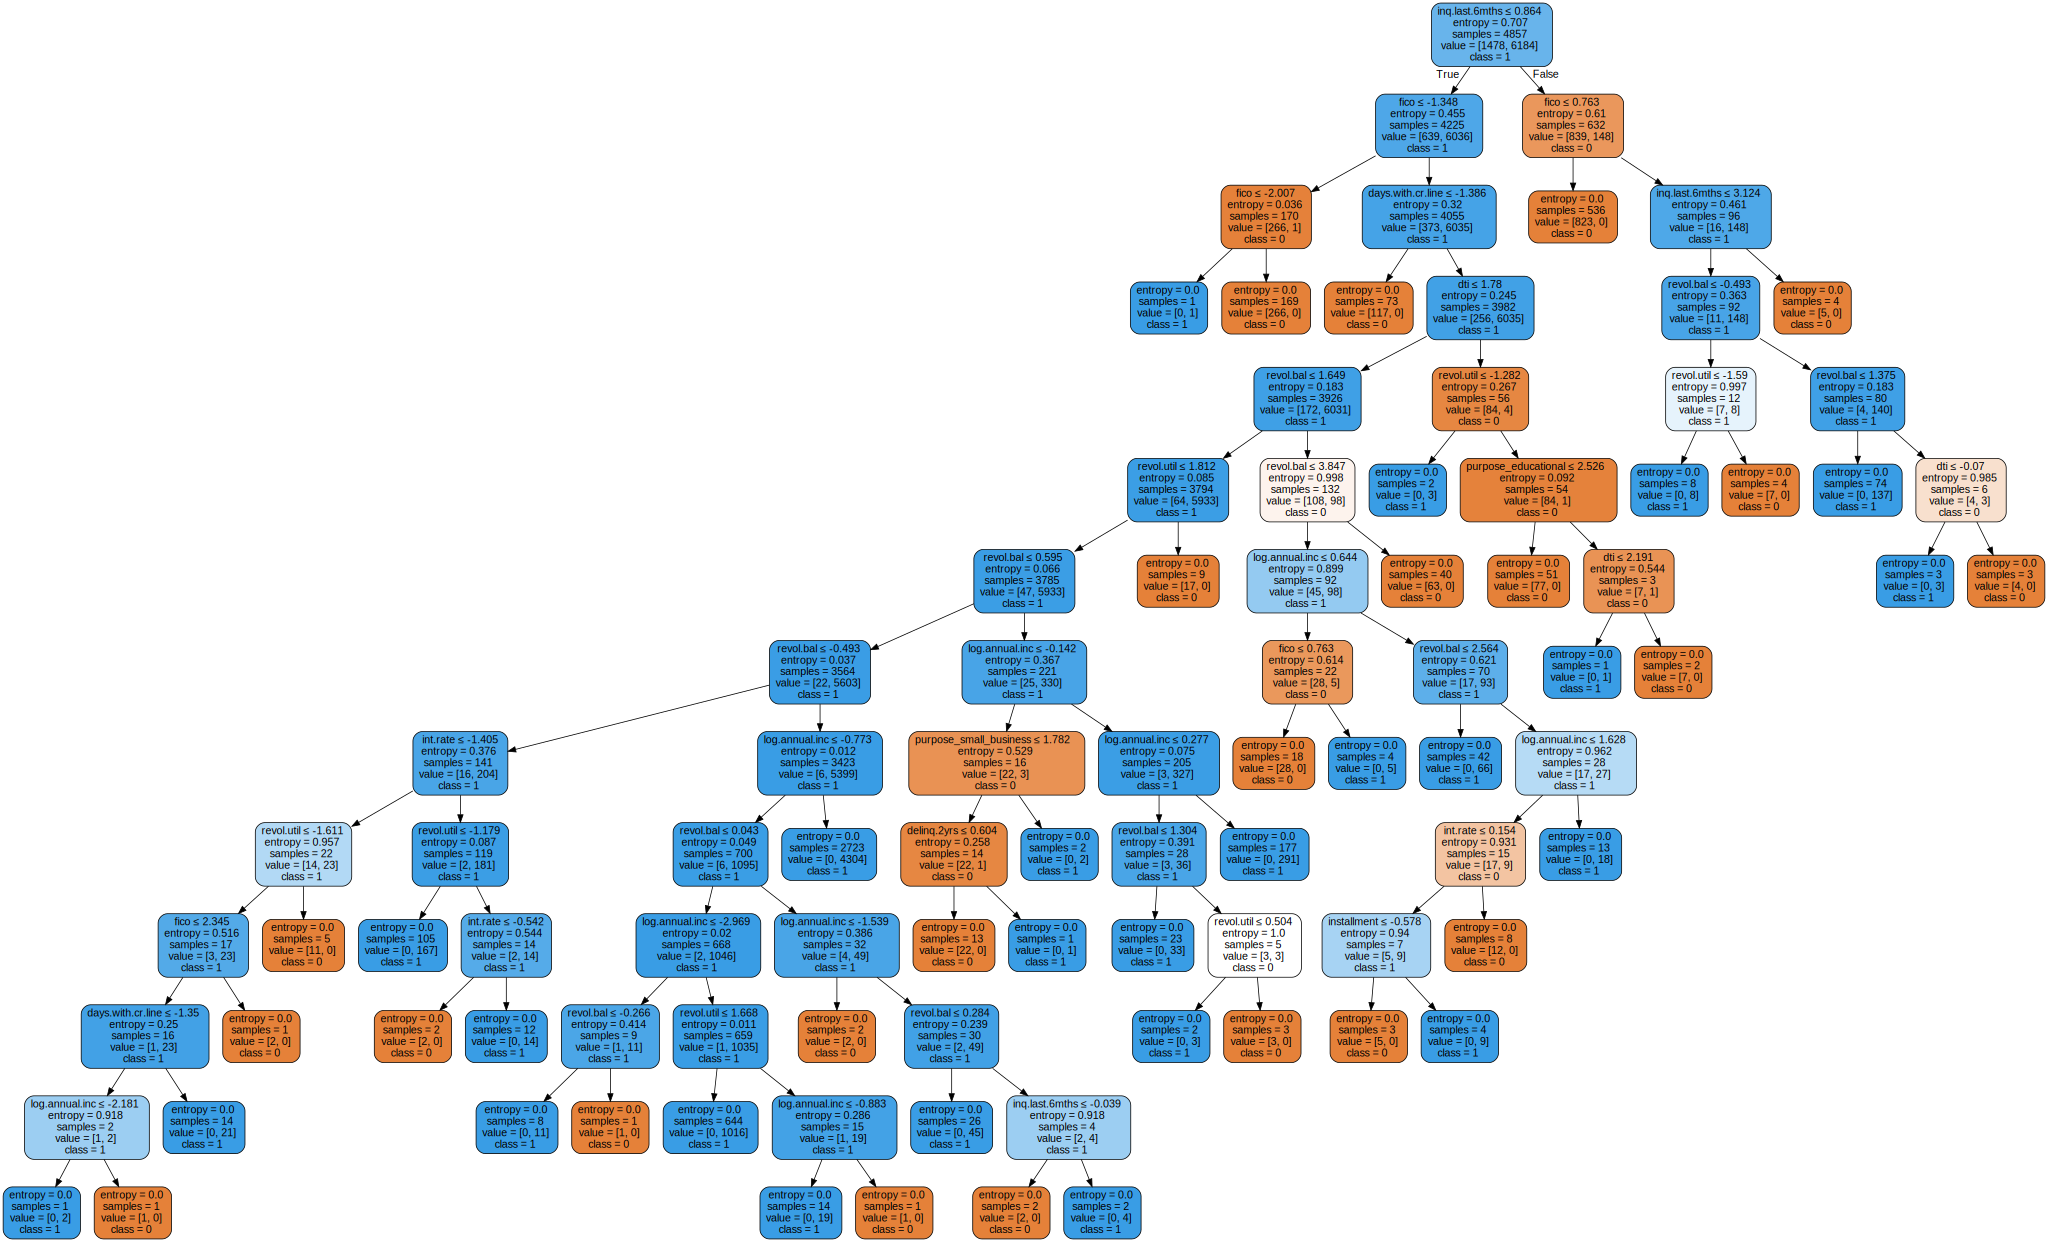

In [83]:
#Random Forest Visualization

graph = plot_tree(RF_clf.estimators_[1])
graph

### Questions
1. How did the DT compare to the RF in performance? Why?
    - The Decision Tree performed slightly worse than Random Forest
    - Reason: Becuase Random Forest is comprised of multiple Decision Trees where then we aggregate the DTs averages. Also the randomness in feature selection helps RF avoid over fitting and get better predictions
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - DT max depth: 10
    - RF max depth: 16
    - Reason: RF max depth is larger because it is falls under the bagging technique. Where the trees get fitted on bootstrap samples from the training set. This produces a big depth because it tries to drop the variance.
3. What is ensemble learning? What are its pros and cons?
    - Ensemble learning captializes on combining decisions from multiple different models to achive better predictive performance than could be attained from any of the individual learning methods alone.
    - According to empirical studies, predictions made using several models frequently perform better. “Wisdom of crowds”
    - Pros: 
      - Better predictions
      - Stable and robust
      - Captures linear and non-linear relationships
    - Cons: 
      - Hard to interpret 
      - Computationally expensive
      - Selecting the models is a hard problem
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - Boosting: 
      - AdaBoost: a statistical classification meta-algorithm. It is used with other learning algorithms to improve performance by combining the output of the other learning algorithms into a weighted sum that represents the final output.
      - Gradient Boosting: a technique where it ensembles weak prediction models and produces a model which is usually in the form of decision trees.
    - Bagging:
      - Bagging Meta-Estimator: produces several instances of an estimator on random portions of the training set and aggregates the individual predictions to make a final prediction
      - Random Forest: a meta estimator which fits decision tree classifiers on different sub-samples of the dataset. Uses averaging to avoid overfitting and to have better predictions
    - RF falls under bagging

- References:
  - https://towardsdatascience.com/random-forest-3a55c3aca46d
  - https://towardsdatascience.com/why-random-forests-outperform-decision-trees-1b0f175a0b5
  - https://www.kdnuggets.com/2022/02/random-forest-decision-tree-key-differences.html
  - https://www.soa.org/4a6af7/globalassets/assets/files/e-business/pd/events/2020/predictive-analytics-4-0/pd-2020-09-pas-session-014.pdf
  - https://blog.knoldus.com/ensemble-learning-its-methods-in-machine-learning/
  - https://medium.com/@aravanshad/ensemble-methods-95533944783f
  - https://en.wikipedia.org/wiki/Ensemble_learning
  - https://scikit-learn.org/stable/modules/ensemble.html
  - https://www.geeksforgeeks.org/bagging-vs-boosting-in-machine-learning/#:~:text=The%20Random%20Forest%20model%20uses,trees%20make%20a%20Random%20Forest.
  - https://en.wikipedia.org/wiki/AdaBoost
  -

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [58]:
# Unzip the file

with zipfile.ZipFile('svhn.zip', 'r') as zip_ref:
    zip_ref.extractall('/task4/')

In [59]:
# Adjust parse_data function to adapt for new directory structure

def parse_data(dir):
  X = []
  y = []
  for img in os.listdir(dir):
    datum = plt.imread(f'{dir}/{img}')
    datum = rgb2gray(datum)
    tr = transforms.ToTensor()
    datum = tr(datum)  
    rs = transforms.Resize((84,84))
    datum = rs(datum)
    X.append(datum)
    y.append(img.split('.')[0])
  return X, y

In [60]:
# Parse data

X_test, y_test = parse_data('/task4/svhn')

test_data = CustumData(X_test, y_test)

In [61]:
# Testing

def testing(net, device, testloader):
  net.eval()
  test_corrects = 0
  for data, targets in testloader:
    with torch.no_grad():
      data = data.to(device).float()
      targets = torch.tensor([[int(target[0]), int(target[1]), int(target[2])] for target in targets])
      targets = targets.to(device)
      
      outputs = net(data) 

      for i in range(3):
        preds = torch.max(outputs[i], 1)[1]
        test_corrects += torch.sum(preds == targets[:, i])
  acc = test_corrects.double() / (len(test_data)*3)
  return acc

In [63]:
# Main

def main_task4():
  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda"
  testloader = DataLoader(test_data, batch_size=1024, shuffle=True)
  acc = testing(best_cnn, device, testloader)
  print(f'Accuracy: {acc}')

main_task4()

Accuracy: 0.08333333333333333


### Questions
1. How did your model perform? Why is it better/worse?
    - Accuracy: 0.08333333333333333
    - The model performed much worse.
    - Reason: 
      - Although the idea of the problem the model is trying to solve is the same, it is still a much different problem.
      - The testing data is extremely different from triple_mnist, where the images contain various other objects of different colors and the pictures of the numbers are taken from different angles which adjusts how the numbers look. Where on the other hand mnist dataset is only handwritten numbers with the samle color due to how the pictures look and my grayscaling, and it was trained to predict only that kind of pictures with slight modifications in rotation due to the augmentation I implemented.
2. What is domain gap in the context of ML?
    - A domain gap or also known as domain shift is a shift in the data distribution between a dataset used for training an algorithm and the dataset it will encounter when it is used. These domain changes occur often in real-world AI applications. Traditional machine learning methods frequently don't adapt well to domain changes.
3. Suggest two ways through which the problem of domain gap can be tackled.
    - There are multiple ways to tackle this problem In the field of Domain Adaptation.
    - Note: Because I don't fully understand if you want 2 algorithms or 2 general descriptions of Domain Adaptation methods I will just write 2 algorithms and 2 general descriptions.
    - General ways:
      - 1) Unsupervised Domain Adaptation
        - Where learning includes two sets of labeled and unlabeled source examples, and a set of unlabled target examples 
      - 2) Semi-Supervised Domain Adaptation
        - Where in this situation, we also include a small set of labeled target examples.
    - Algorthims:
      - 1) Reweighting
        - Where we try to reweight the source labeled sample so it would resemble the target sample.
      - 2) Search of a common representation space
        - Where we try to make a common representation space where the two domains are close but keep a good performance in the source task. 

- References: 
    - https://en.wikipedia.org/wiki/Domain_adaptation#:~:text=Domain%20adaptation%20is%20the%20ability,a%20subcategory%20of%20transfer%20learning.
    - https://machinelearning.apple.com/research/bridging-the-domain-gap-for-neural-models 